In [1]:
!pip install navec
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 34.7 MB/s 
     |████████████████████████████████| 578.0 MB 19 kB/s 
     |████████████████████████████████| 1.7 MB 54.4 MB/s 
     |████████████████████████████████| 438 kB 67.1 MB/s 
     |████████████████████████████████| 5.9 MB 76.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstal

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text as tf_text
from navec import Navec

In [4]:
class Nl2SqlTranslator(tf.keras.Model):
    def __init__(self, nl_text_processor, sql_text_processor, navec, unit=300):
        super().__init__()
        # Natural language
        self.nl_text_processor = nl_text_processor
        self.nl_voba_size = len(nl_text_processor.get_vocabulary())
        
        self.nl_embedding = tf.keras.layers.Embedding(
            self.nl_voba_size,
            output_dim=unit,
            mask_zero=True)
        
        fixed_embedding_matrix = np.zeros((self.nl_voba_size, unit))
        for i, word in enumerate(nl_text_processor.get_vocabulary()):
            fixed_embedding_matrix[i] = navec.get(word, navec['<pad>'])
        self.fixed_embedding = tf.keras.layers.Embedding(
            input_dim=self.nl_voba_size,
            output_dim=unit,
            embeddings_initializer=tf.keras.initializers.Constant(fixed_embedding_matrix),
            trainable=False,
            mask_zero=True)
        
        self.nl_rnn = tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(int(unit/2), return_sequences=True, return_state=True))
        # Attention
        self.attention = tf.keras.layers.Attention()
        # SQL
        self.sql_text_processor = sql_text_processor
        self.sql_voba_size = len(sql_text_processor.get_vocabulary())
        self.sql_embedding = tf.keras.layers.Embedding(
            self.sql_voba_size,
            output_dim=unit,
            mask_zero=True)
        self.sql_rnn = tf.keras.layers.LSTM(unit, return_sequences=True, return_state=True)
        # Output
        self.out = tf.keras.layers.Dense(self.sql_voba_size)
            
    def __call__(self, nl_text, sql_text, training=True):
        nl_tokens = self.nl_text_processor(nl_text) # Shape: (batch, Ts)
        nl_vectors = self.nl_embedding(nl_tokens, training=training) # Shape: (batch, Ts, embedding_dim)
        nl_fixed_vectors = self.fixed_embedding(nl_tokens) # Shape: (batch, Ts, 100)
        nl_combined_vectors = tf.concat([nl_vectors, nl_fixed_vectors], -1) # Shape: (batch, Ts, embedding_dim+100)
        nl_rnn_out, fhstate, fcstate, bhstate, bcstate = self.nl_rnn(nl_combined_vectors, training=training) # Shape: (batch, Ts, bi_rnn_output_dim), (batch, rnn_output_dim) ...
        nl_hstate = tf.concat([fhstate, bhstate], -1)
        nl_cstate = tf.concat([fcstate, bcstate], -1)
        
        sql_tokens = self.sql_text_processor(sql_text) # Shape: (batch, Te)
        expected = sql_tokens[:,1:] # Shape: (batch, Te-1)
        
        teacher_forcing = sql_tokens[:,:-1] # Shape: (batch, Te-1)
        sql_vectors = self.sql_embedding(teacher_forcing, training=training) # Shape: (batch, Te-1, embedding_dim)
        sql_in = self.attention(inputs=[sql_vectors,nl_rnn_out], mask=[sql_vectors._keras_mask, nl_rnn_out._keras_mask], training=training)
        
        trans_vectors, _, _ = self.sql_rnn(sql_in, initial_state=[nl_hstate, nl_cstate], training=training) # Shape: (batch, Te-1, rnn_output_dim)
        out = self.out(trans_vectors, training=training) # Shape: (batch, Te-1, sql_vocab_size)
        return out, expected, out._keras_mask

In [5]:
def train(dataset, epochs, model, batch=64, shuffle=1000):
    loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True,
        reduction=tf.keras.losses.Reduction.NONE)
    opt = tf.keras.optimizers.Adam()
    losses = []
    ds = dataset.shuffle(shuffle).batch(batch).cache()
    
    print("Training started...")
    
    for epoch in range(epochs):
        epoch_losses = []
        for nl_text, sql_text in ds:
            with tf.GradientTape() as tape:
                logits, expected, mask = model(nl_text, sql_text)
                loss = loss_fcn(expected, logits)
                loss = tf.ragged.boolean_mask(loss, mask)
                loss = tf.reduce_sum(loss) * (1. / batch)
                epoch_losses.append(loss.numpy())
                grads = tape.gradient(loss, model.trainable_weights)
                opt.apply_gradients(zip(grads, model.trainable_weights))
        losses.append(np.mean(epoch_losses))
        print('Trained epoch: {}; loss: {}'.format(epoch, losses[epoch]))
        
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Losses')

In [6]:
def split(text):
    parts = tf.strings.split(text, sep='\t')
    return parts[0], parts[1]

In [7]:
def standardize(text):
    # Split accecented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # # Keep space, a to z, and select punctuation.
    # text = tf.strings.regex_replace(text, '[^\w\s.?!,:;\{\}\(\)\[\]]', '')
    # # Add spaces around punctuation.
    # text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [8]:
dataset = tf.data.TextLineDataset(['nl2sql.txt']).map(split)
nl_dataset = dataset.map(lambda nl, sql: nl)
sql_dataset = dataset.map(lambda nl, sql: sql)

In [9]:
nl_text_processor = tf.keras.layers.TextVectorization(standardize=standardize, max_tokens=5000)
sql_text_processor = tf.keras.layers.TextVectorization(standardize=standardize, max_tokens=5000)
nl_text_processor.adapt(nl_dataset.batch(64))
sql_text_processor.adapt(sql_dataset.batch(64))

In [10]:
path = './navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [14]:
model = Nl2SqlTranslator(nl_text_processor, sql_text_processor, navec)

Training started...
Trained epoch: 0; loss: 64.22322082519531
Trained epoch: 1; loss: 63.31948471069336
Trained epoch: 2; loss: 62.11433792114258
Trained epoch: 3; loss: 59.98335266113281
Trained epoch: 4; loss: 56.31269836425781
Trained epoch: 5; loss: 52.59640884399414
Trained epoch: 6; loss: 50.52315139770508
Trained epoch: 7; loss: 48.9955940246582
Trained epoch: 8; loss: 47.619773864746094
Trained epoch: 9; loss: 46.37248229980469
Trained epoch: 10; loss: 45.50846481323242
Trained epoch: 11; loss: 44.73655319213867
Trained epoch: 12; loss: 43.90521240234375
Trained epoch: 13; loss: 43.0961799621582
Trained epoch: 14; loss: 42.4491081237793
Trained epoch: 15; loss: 41.86153030395508
Trained epoch: 16; loss: 41.230228424072266
Trained epoch: 17; loss: 40.52061462402344
Trained epoch: 18; loss: 39.77604675292969
Trained epoch: 19; loss: 39.04479217529297
Trained epoch: 20; loss: 38.279396057128906
Trained epoch: 21; loss: 37.443641662597656
Trained epoch: 22; loss: 36.576969146728516

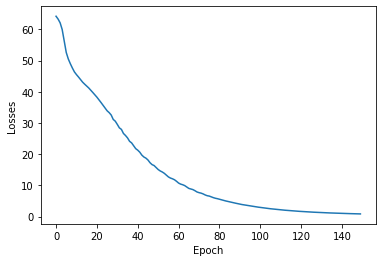

In [15]:
train(dataset, 150, model)

In [16]:
def translate(nl_text, model, max_seq=100):
    nl_tokens = model.nl_text_processor([tf.constant(nl_text)]) # Shape: (batch, Ts)
    nl_vectors = model.nl_embedding(nl_tokens, training=False) # Shape: (batch, Ts, embedding_dim)
    nl_fixed_vectors = model.fixed_embedding(nl_tokens) # Shape: (batch, Ts, 100)
    nl_combined_vectors = tf.concat([nl_vectors, nl_fixed_vectors], -1) # Shape: (batch, Ts, embedding_dim+100)
    nl_rnn_out, fhstate, fcstate, bhstate, bcstate = model.nl_rnn(nl_combined_vectors, training=False) # Shape: (batch, Ts, bi_rnn_output_dim), (batch, rnn_output_dim) ...
    nl_hstate = tf.concat([fhstate, bhstate], -1)
    nl_cstate = tf.concat([fcstate, bcstate], -1)
    state = [nl_hstate, nl_cstate]

    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=model.sql_text_processor.get_vocabulary(),
        mask_token='')
    trans = ['[START]']
    vectors = []

    for i in range(max_seq):
        token = index_from_string([[trans[i]]]) # Shape: (1, 1)
        vector = model.sql_embedding(token, training=False) # Shape: (1, 1, embedding_dim)
        vectors.append(vector)
        query = tf.concat(vectors, axis=1)
        context = model.attention(inputs=[query, nl_rnn_out], training=False)
        trans_vector, hstate, cstate = model.sql_rnn(context[:,-1:,:], initial_state=state, training=False) # Shape: (1, 1, rnn_output_dim), (1, rnn_output_dim), (1, rnn_output_dim)
        state = [hstate, cstate]
        out = model.out(trans_vector) # Shape: (1, 1, eng_vocab_size)
        out = tf.squeeze(out) # Shape: (eng_vocab_size,)
        word_index = tf.math.argmax(out)
        word = model.sql_text_processor.get_vocabulary()[word_index]
        trans.append(word)
        if word == '[END]':
            trans = trans[:-1]
            break
    _, atts = model.attention(inputs=[vectors, nl_rnn_out], return_attention_scores=True, training=False)
    return ' '.join(trans[1:]), atts

In [19]:
translate("Какие адреса где были соревнования лишь один раз", model)[0]

'select * from (select address, count(*) c from sport s group by address) s where c = 1'